<a href="https://colab.research.google.com/github/risa1796/Computer-Vision-exercises/blob/main/RoomTypeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/딥러닝기초/Home24

/content/drive/MyDrive/딥러닝기초/Home24


In [3]:
device = 'cuda'

In [4]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
from glob import glob


In [5]:
data_dir = '/content/drive/MyDrive/딥러닝기초/Home24/images'

In [6]:
import os 

classes = os.listdir(data_dir)
classes

['livingroom', 'bathroom', 'kitchen']

-------------livingroom-------------


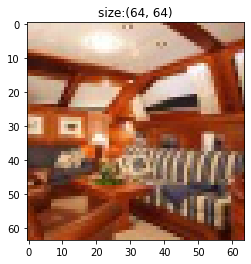

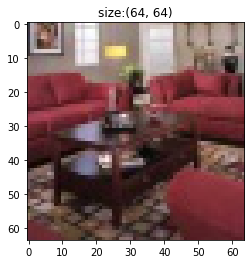

-------------bathroom-------------


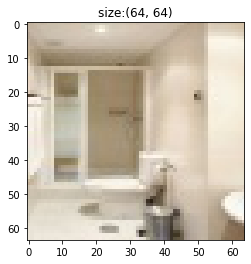

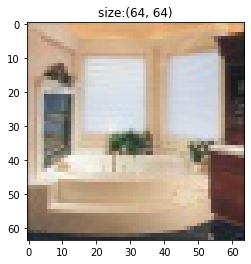

-------------kitchen-------------


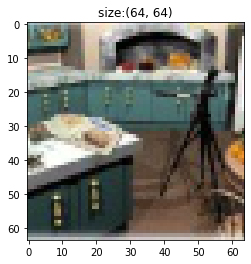

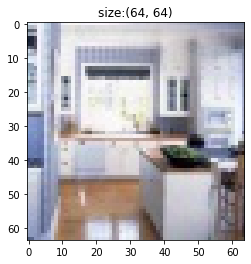

In [7]:
for cl in classes:
  print(f'-------------{cl}-------------')
  image_path = data_dir + '/' + cl + '/'
  image_paths = glob(os.path.join(image_path,  '*'))
  for _ in range(2):
    idx = np.random.randint(0, len(image_paths))
    image = Image.open(image_paths[idx])
    plt.imshow(image)
    plt.title(f'size:{image.size}')
    plt.show() 

In [8]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [9]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# We apple our transformations using ImageFolder
dataset = ImageFolder(data_dir, transform = transformations)

In [10]:
dataset

Dataset ImageFolder
    Number of datapoints: 385
    Root location: /content/drive/MyDrive/딥러닝기초/Home24/images
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [11]:
train_ratio = int(len(dataset)*0.6)
val_ratio = int(len(dataset)*0.3)
test_ratio = int(len(dataset)*0.1)+1

In [12]:
from torch.utils.data import random_split

train_ds, val_ds, test_ds = random_split(dataset, [train_ratio,val_ratio,test_ratio])
len(train_ds), len(val_ds), len(test_ds)

(231, 115, 39)

In [13]:
tr_values = [item[1] for item in train_ds]

In [14]:
from collections import Counter

Counter(tr_values)

Counter({1: 55, 2: 86, 0: 90})

In [15]:
from torch.utils.data import Dataset

class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [16]:
from torchvision.transforms.transforms import RandomVerticalFlip
data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAutocontrast(),
        transforms.RandomAdjustSharpness(0.5),
        transforms.RandomVerticalFlip(0.5)])

In [17]:
train_ds = ApplyTransform(train_ds, transform=data_transforms)
val_ds = ApplyTransform(val_ds, transform=data_transforms)

In [18]:
from torch.utils.data.dataloader import DataLoader
batch_size = 16

In [19]:
train_loader = DataLoader(train_ds,
                            batch_size,
                            num_workers = 4,
                            shuffle=True)
val_loader = DataLoader(val_ds,
                         batch_size,
                         num_workers = 4,
                        shuffle=True)

test_loader = DataLoader(test_ds,
                        batch_size,
                        shuffle=False)

In [20]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

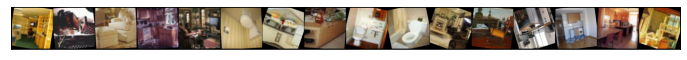

In [21]:
show_batch(val_loader)

In [22]:
def train(model, trainLoader):
    model.to(device)
    model.train()
    train_loss = 0
    train_acc = 0
    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader.dataset)
    return train_loss, train_acc

In [23]:
def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

In [24]:
# Use pretrained GoogLeNet
googlenet = torchvision.models.googlenet(pretrained=True)
googlenet = googlenet.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
googlenet.fc = nn.Linear(1024, 3, device=device)

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(googlenet.parameters(), lr=1e-3)

In [27]:
N_EPOCH = 30

for epoch in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch}')
    loss, accuracy = train(googlenet, train_loader )
    val_loss, val_accuracy = test(googlenet, test_loader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))

EPOCH 1
     Train | Loss :  0.9421, Accuracy :  56.28 %
Validation | Loss :  1.5077, Accuracy :  20.51 %

EPOCH 2
     Train | Loss :  0.7348, Accuracy :  66.23 %
Validation | Loss :  0.7533, Accuracy :  71.79 %

EPOCH 3
     Train | Loss :  0.5973, Accuracy :  74.46 %
Validation | Loss :  0.7764, Accuracy :  71.79 %

EPOCH 4
     Train | Loss :  0.4755, Accuracy :  85.28 %
Validation | Loss :  0.6522, Accuracy :  74.36 %

EPOCH 5
     Train | Loss :  0.3655, Accuracy :  89.18 %
Validation | Loss :  0.6877, Accuracy :  76.92 %

EPOCH 6
     Train | Loss :  0.3434, Accuracy :  89.18 %
Validation | Loss :  0.6969, Accuracy :  76.92 %

EPOCH 7
     Train | Loss :  0.2467, Accuracy :  92.21 %
Validation | Loss :  0.8414, Accuracy :  74.36 %

EPOCH 8
     Train | Loss :  0.2233, Accuracy :  94.81 %
Validation | Loss :  0.6661, Accuracy :  82.05 %

EPOCH 9
     Train | Loss :  0.1620, Accuracy :  96.97 %
Validation | Loss :  0.6539, Accuracy :  82.05 %

EPOCH 10
     Train | Loss :  0.1718,

In [28]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [29]:
True_cnt = 0
False_cnt = 0

for i in range(len(test_ds)):
  img, label = test_ds[i]
  if dataset.classes[label] == predict_image(img, googlenet):
    True_cnt += 1
  else:
    False_cnt += 1

print(f'Model was able to classify {True_cnt} images correctly!')
print(f'Model was wrong {False_cnt} times.')

Model was able to classify 32 images correctly!
Model was wrong 7 times.


In [30]:
print(f'{round((False_cnt/(False_cnt+True_cnt))*100)}% of total test dataset were classified wrong.')

18% of total test dataset were classified wrong.


Label: livingroom , Predicted: livingroom


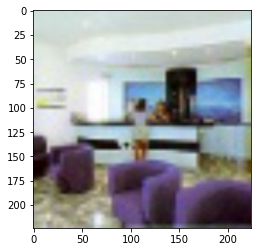

Label: livingroom , Predicted: kitchen


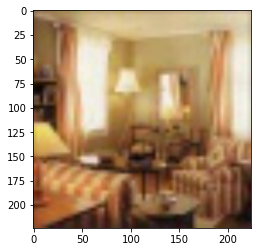

Label: bathroom , Predicted: bathroom


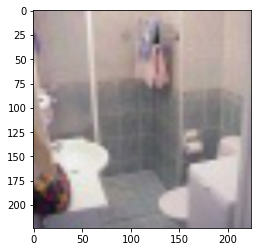

Label: livingroom , Predicted: livingroom


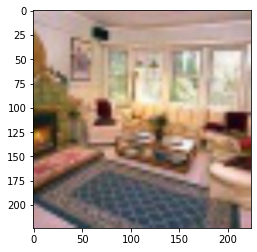

Label: kitchen , Predicted: kitchen


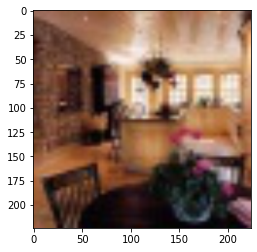

Label: kitchen , Predicted: kitchen


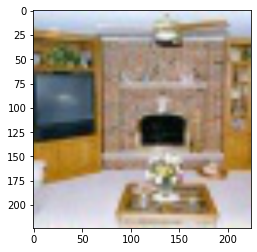

Label: kitchen , Predicted: kitchen


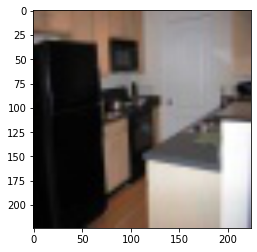

Label: kitchen , Predicted: bathroom


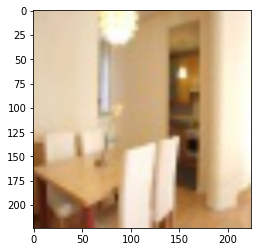

Label: livingroom , Predicted: livingroom


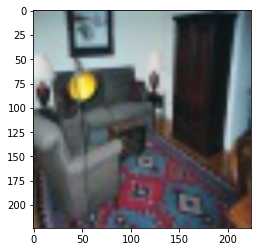

In [31]:
for i in range(11,20):
  img, label = test_ds[i]
  print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, googlenet))
  plt.imshow(img.permute(1, 2, 0))
  plt.show()